## EBM 결과로 What-if 인사이트 찾기


In [2]:
### 전략
# + Fill na 만 할때 성능이 가장 좋음(log, category trick, interaction term 다 필요 없음)
# + overrallqual 의 importance가 가장 높음
# + 너ㅁ

### Library

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy.stats import norm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
## sklearn.preprocessing.Imputer -> sklearn.impute.SimpleImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, cross_val_predict
import os
# print(os.listdir("../input"))

### Load housing data

In [3]:
df_train = pd.read_csv("../data/raw/house/train.csv")
df_test = pd.read_csv("../data/raw/house/test.csv")

In [4]:
print(df_train.shape, df_test.shape)

(1460, 81) (1459, 80)


### Data Exploration

In [5]:
## sample train
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [6]:
#Show all columns
pd.options.display.max_columns = None
df_train.describe()

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

In [7]:
pd.options.display.max_columns = None
df_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [8]:
## 변수별 type
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [423]:
## convert numeric to string
df_train["MSSubClass"] = df_train["MSSubClass"].apply(str)
df_train['YrSold'] = df_train['YrSold'].apply(str)
df_train['MoSold'] = df_train['MoSold'].apply(str)
# df_train.info()

### Missing Data

In [10]:
df_na = (df_train.isnull().sum() / len(df_train)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending = False)
missing_data = pd.DataFrame({"Missing Ratio": df_na})

df_na_cols = pd.DataFrame(df_train.dtypes)
missing_data = missing_data.join(df_na_cols, how = 'left')

In [425]:
# missing_data

In [426]:
len(missing_data)

19

## Profiling report

In [13]:
## profile report -> save html
from pandas_profiling import ProfileReport
# profile = ProfileReport(df_train,
#                        explortative = True,
#                        )

pr = df_train.profile_report()

# pr.to_file('./data_profile/03_01_housing_profile.html')

## Target analysis
### Distribution of target is skewed -> Log transform

In [14]:
fig, ax = plt.subplots(1, 2)
width, height = fig.get_size_inches()
fig.set_size_inches(width*2, height)
sns.distplot(df_train['SalePrice'], ax = ax[0], fit = norm)
sns.distplot(np.log(df_train[('SalePrice')]+1), ax = ax[1], fit=norm)

/Users/a420777/opt/anaconda3/envs/whatif/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/a420777/opt/anaconda3/envs/whatif/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

## Data Engineering
+ Handling categoricals
+ Feature engineering - To generate new features

### Fill missing value

In [15]:
## Fill with the supplied value
def fill_missing(df, cols, val):
    for col in cols:
        df[col] = df[col].fillna(val)
        
## Fill with the mode
def fill_missing_with_mode(df, cols):
    for col in cols:
        df[col] = df[col].fillna(df[col].mode()[0])
        
## log transform for columns
def add_log(res, cols):
    m = res.shape[1]
    for col in cols:
        res = res.assign(newcol = pd.Series(np.log(1.01 + res[col])).values)
        res.columns.values[m] = col + '_log'
        m +=1
    
    return res

In [16]:
cat_null_cols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu","GarageType", "GarageFinish", "GarageQual", "GarageCond",
                 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
                "MasVnrType", "MSSubClass", "Electrical"]

num_null_cols = ['GarageYrBlt', 'MasVnrArea']

fill_missing(df_train, cat_null_cols, "None")
fill_missing(df_train, num_null_cols, 0)

# house co located are similar in size
df_train['LotFrontage'] = df_train.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

### Add new feature

In [17]:
## total square feet
df_train["TotalSF"] = df_train['TotalBsmtSF'] + df_train['1stFlrSF'] + df_train['2ndFlrSF']

### Handle categorical value
+ EBM에선 categorical value를 dummy로 만드는게 역효과!!

In [18]:
# def dummy_encode(in_df_train):
#     df_train = in_df_train
#     categorical_features = [col  for col in df_train.columns if df_train[col].dtype == 'object']
#     print(categorical_features)
    
#     for f in categorical_features:
#         prefix = f
#         df_train = pd.concat([df_train, pd.get_dummies(df_train[f], prefix = prefix)], axis=1).drop(f,axis=1)
        
#     return df_train

In [19]:
# df_train = dummy_encode(df_train)
# print(df_train.shape)

## Modeling(EBM)

In [258]:
# interpretml EBM
from interpret import show
from interpret.data import Marginal
from interpret.glassbox import ExplainableBoostingRegressor, LinearRegression, RegressionTree

X = df_train.drop(['Id', 'SalePrice'], axis= 1)
y = df_train.SalePrice

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state= 42)

In [422]:
marginal = Marginal().explain_data(X_train, y_train, name = 'Train Data')
# show(marginal)

In [22]:
# Explainable boosting regressor
ebm = ExplainableBoostingRegressor(random_state= 42)
ebm.fit(X_train, y_train)


ExplainableBoostingRegressor(feature_names=['MSSubClass', 'MSZoning',
                                            'LotFrontage', 'LotArea', 'Street',
                                            'Alley', 'LotShape', 'LandContour',
                                            'Utilities', 'LotConfig',
                                            'LandSlope', 'Neighborhood',
                                            'Condition1', 'Condition2',
                                            'BldgType', 'HouseStyle',
                                            'OverallQual', 'OverallCond',
                                            'YearBuilt', 'YearRemodAdd',
                                            'RoofStyle', 'RoofMatl',
                                            'Exterior1st', 'Exterior2nd',
                                            'MasVnrTy...
                                            'categorical', 'categorical',
                                            'categorical', 'cate

In [420]:
 #performance
from interpret.perf import RegressionPerf
ebm_perf = RegressionPerf(ebm.predict).explain_perf(X_valid, y_valid, name = 'EBM')
# show(ebm_perf)

In [419]:
# ebm global
ebm_global = ebm.explain_global(name = 'EBM')
# show(ebm_global)

# Hypothesis 2 - (Global) 어떤 x를 바꾸어야 집 가격을 가장 많이 올릴 수 있을까?

## 1) 인사이트: global 관점에서 기대 수익의 변동에 대한 이해
        -> 전체 데이터셋의 관점에서 기대 수익 변동이 큰 피처를 알아냄으로써, 전체 매물 대상으로 마진을 극대화할 수 있는 전략 도출

## 2) 활용처: global한 feature variation 관점에서의 전략 도출
		-> 우리의 인스턴스들이 어떤 특징을 갖는 방향이 바람직한지에 대한 시뮬레이션이 가능함. 
		-> 전체 데이터 타겟을 대상으로 비즈니스 목적에 부합하는 massive한 전략을 도출할 수 있음.

## 3) 분석: 

### 분석 방법  
        -> 가용 feature 관점으로, 변화하는 양상에 따른 누적 최대 이익을 시각화(투입 비용을 배제하고, 실제 가격 대비 예측 마진을 누적으로 기록)함.
		-> 이를 모든 feature를 대상으로 반복하여 시행, 전체 플롯을 통해 최대한의 이익을 얻을 수 있는 액션을 도출
		-> 투입 비용을 배제한 이유는, 이윤 극대화라는 목표를 달성함에 있어 투입 비용은 하나의 제약조건일 뿐이므로 수익의 가능한 영역을 쭉 그려 놓으면 추가적으로 비용에 대한 제약을 추가했을 경우 현실적인 결과가 나올 것이기 때문

In [473]:
# 시각화에 필요한 플롯팅 함수 정의

import plotly.graph_objects as go
from plotly.subplots import make_subplots

scores_range=(-98365.92454651206, 102145.65757499124)

def create_time_series(df, colname):
    
    dff=df[df.col_name==colname]
    trace1 = go.Line(
        x=dff['names'],
        y=dff['scores'],
        name='scores',
        marker=dict(
            color='rgb(34,163,192)',
            size=1),
        line_shape="vh",
        line_dash="solid"
    )
    trace2 = go.Scatter(
        x=dff['names'],
        y=dff['upper_bounds'],
        name='upper_bounds',
        marker=dict(
            color='rgb(12,100,100)',
            size=0.1),
        line_shape="vh",
        line_dash="solid"
    )
    
    trace3 = go.Scatter(
        x=dff['names'],
        y=dff['lower_bounds'],
        name='lower_bounds',
        marker=dict(
            color='rgb(200,1,100)',
            size=0.1),
        line_shape="vh",
        line_dash="solid"
    )
    
    fig = make_subplots()
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.add_trace(trace3)

    fig.update_xaxes(showgrid=False)
    fig.update_layout(height=400,width=400*1.618) # , yaxis_range=list(scores_range))
#     fig.show()
    
    return fig

In [202]:
import copy

In [203]:
global_internal_obj=copy.deepcopy(ebm_global._internal_obj)

In [212]:
# len(tar['names'])
# len(tar['scores'])
# len(tar['upper_bounds'])
# len(tar['lower_bounds'])

In [209]:
global_info_list=[]

In [210]:
global_data=global_internal_obj["specific"]

In [211]:
for i in range(X_train.shape[1]):
    
    col_name=X_train.columns[i]
    
    tar=global_data[i]
    scores_range=tar.pop("scores_range")
    density=tar.pop("density")
    
    if len(tar['names'])!=len(tar['scores']):
        tar["names"]=tar["names"][:-1]
    
    tar=pd.DataFrame(tar)
    tar["col_name"]=col_name
    
    global_info_list.append(tar)
    

In [213]:
global_df=pd.concat(global_info_list,axis=0)

In [219]:
global_df["abs_scores"]=global_df.scores.apply(abs)

In [244]:
# global_df.groupby("col_name").scores.mean().sort_values()

In [238]:
unchangable_features=['MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','LotConfig','LandSlope','Neighborhood','Condition1','Condition2',
                     'BldgType','HouseStyle','MasVnrType','MasVnrArea','Foundation','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',
                     'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
                     'GarageCars','GarageArea','WoodDeckSF','OpenPorchSF','PoolArea','3SsnPorch','EnclosedPorch','ScreenPorch','TotalSF','PoolQC']

In [239]:
changable_features=set(X_train.columns)-set(unchangable_features)

In [240]:
changable_features=list(changable_features)

In [241]:
global_df_avl=global_df[global_df.col_name.isin(changable_features)]

In [381]:
global_df_avl.groupby("col_name").abs_scores.mean().sort_values(ascending=False).head(20)

col_name
OverallQual      8933.560446
OverallCond      6319.690808
Functional       6254.564086
ExterQual        5669.193833
RoofMatl         5235.778745
Fireplaces       5162.162875
KitchenQual      5038.198547
GarageType       4283.548818
GarageQual       4164.399629
SaleType         3811.453447
SaleCondition    3795.880891
BsmtQual         3636.707036
Heating          3531.816699
RoofStyle        3473.188179
GarageCond       3027.798274
YearRemodAdd     2772.609978
CentralAir       2703.031047
ExterCond        2697.336710
FireplaceQu      2608.292871
BsmtCond         2284.606753
Name: abs_scores, dtype: float64

In [242]:
top_avl_features=global_df_avl.groupby("col_name").abs_scores.mean().sort_values(ascending=False).head(20).index

In [243]:
top_avl_features

Index(['OverallQual', 'OverallCond', 'Functional', 'ExterQual', 'RoofMatl',
       'Fireplaces', 'KitchenQual', 'GarageType', 'GarageQual', 'SaleType',
       'SaleCondition', 'BsmtQual', 'Heating', 'RoofStyle', 'GarageCond',
       'YearRemodAdd', 'CentralAir', 'ExterCond', 'FireplaceQu', 'BsmtCond'],
      dtype='object', name='col_name')

In [285]:
# for col in top_avl_features:
#     print(X_train[col].value_counts())

In [298]:
top_avl_features_dtypes=X_train.dtypes[X_train.dtypes.index.isin(top_avl_features)]

In [302]:
top_avl_features_int=top_avl_features_dtypes[top_avl_features_dtypes=="int64"].index
top_avl_features_obj=top_avl_features_dtypes[top_avl_features_dtypes=="object"].index


### Original mean price (baseline)

In [265]:
original_result=ebm.predict(X_valid)

In [266]:
original_result.mean()

178441.53320796875

# Numeric Features

In [557]:
top_avl_features_int

Index(['OverallQual', 'OverallCond', 'YearRemodAdd', 'Fireplaces'], dtype='object')

## OverallQual

In [495]:
X_valid_cp=X_valid.copy()

In [496]:
min_val_OverallQual=X_train.OverallQual.value_counts().index.min()

In [497]:
max_val_OverallQual=X_train.OverallQual.value_counts().index.max()

In [498]:
create_time_series(global_df, "OverallQual")

In [499]:
def OverallQual_addone(x,k):
#     x=int(x)
    
    if x+k>=max_val_OverallQual:
        return max_val_OverallQual
    
    elif x+k<=min_val_OverallQual:
        return min_val_OverallQual
    
    else:
        return x+k

In [501]:
OverallQual_result={}
for i in range(-max_val_OverallQual,max_val_OverallQual):
    X_valid_cp=X_valid.copy()
    X_valid_cp["OverallQual"]=X_valid_cp["OverallQual"].apply(OverallQual_addone, args={i})
    OverallQual_pred=ebm.predict(X_valid_cp)
    exp_profit=np.sum(OverallQual_pred-y_valid.values)
    OverallQual_result[i]=exp_profit
    

In [502]:
OverallQual_df=pd.DataFrame(data=OverallQual_result.values(),index=OverallQual_result.keys(), columns=["expected_profit"])

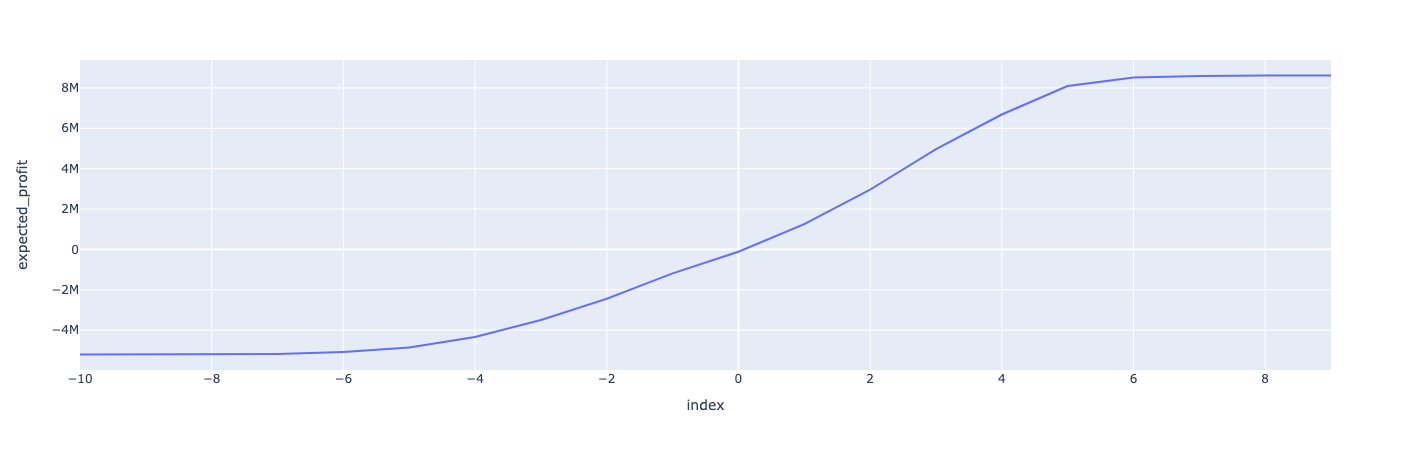

In [503]:
import plotly.express as px

fig = px.line(OverallQual_df, x=OverallQual_df.index, y="expected_profit")
fig.show()

## OverallCond

In [504]:
X_valid_cp=X_valid.copy()

In [491]:
min_val_OverallCond=X_train.OverallCond.value_counts().index.min()

In [505]:
min_val_OverallCond=X_train.OverallCond.value_counts().index.min()

/Users/a420777/opt/anaconda3/envs/whatif/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




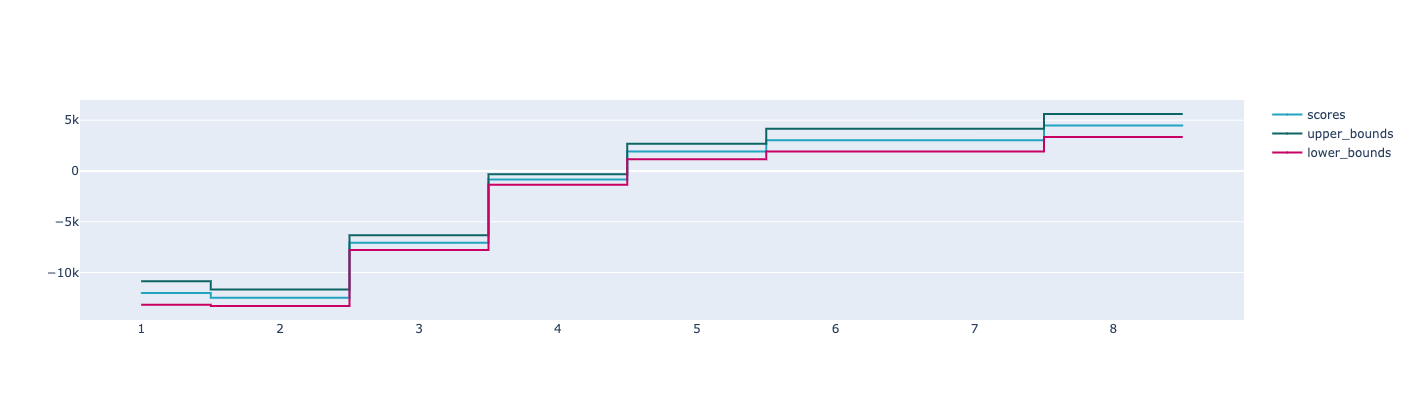

In [493]:
create_time_series(global_df, "OverallCond")

In [506]:
max_val_OverallCond=X_train.OverallCond.value_counts().index.max()

In [462]:
OverallCond_result={}
for i in range(-max_val_OverallCond,max_val_OverallCond):
    X_valid_cp=X_valid.copy()
    X_valid_cp["OverallCond"]=X_valid_cp["OverallCond"].apply(OverallCond_addone, args={i})
    OQ_pred=ebm.predict(X_valid_cp)
    exp_profit=np.sum(OQ_pred-y_valid.values)
    OQ_result[i]=exp_profit
    

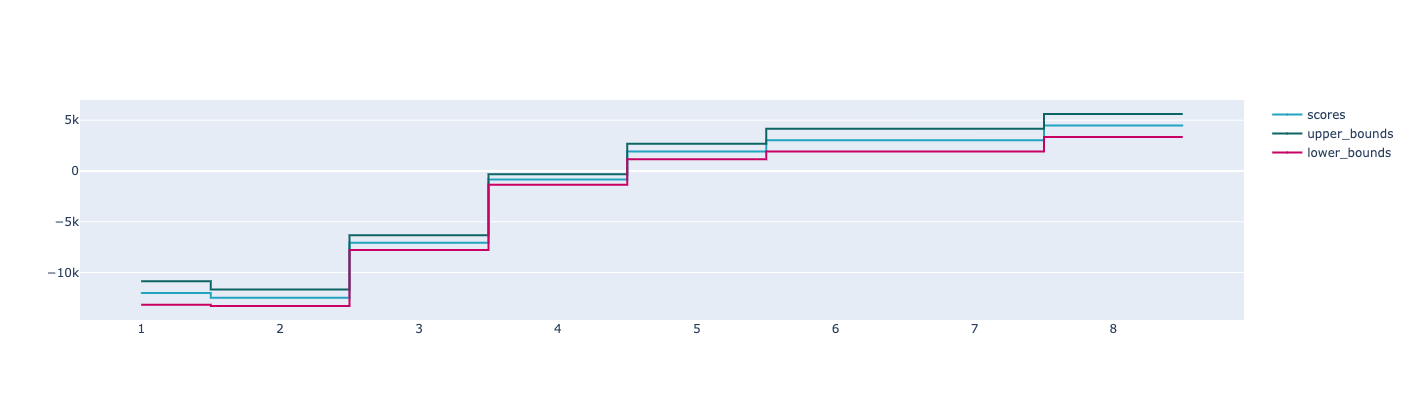

In [507]:
create_time_series(global_df, "OverallCond")

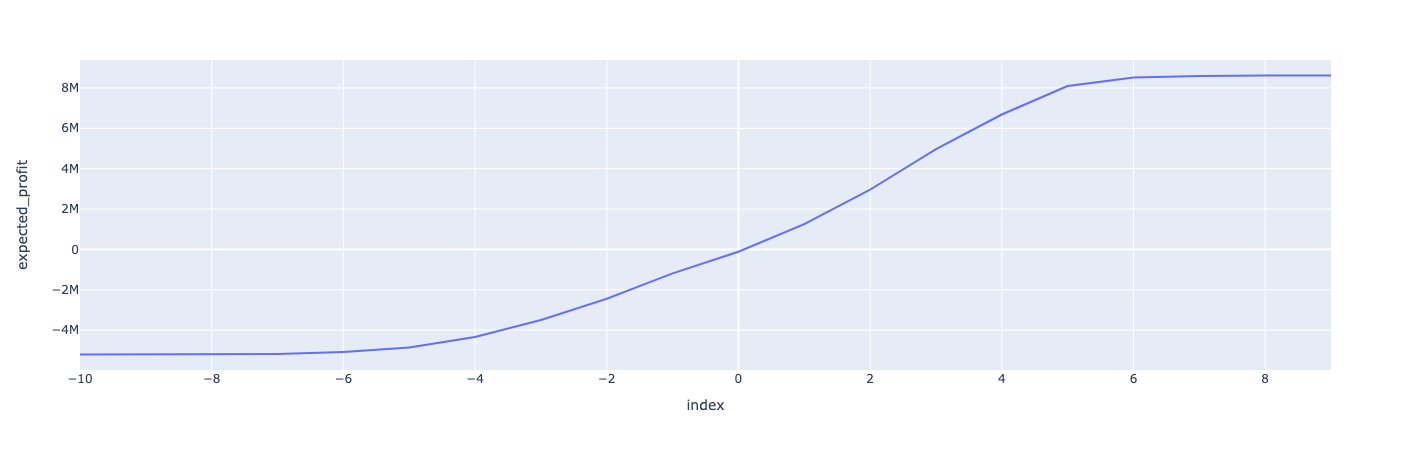

In [489]:
import plotly.express as px

fig = px.line(OQ_df, x=OQ_df.index, y="expected_profit")
fig.show()

In [508]:
def OverallCond_addone(x,k):
#     x=int(x)
    
    if x+k>=max_val_OverallCond:
        return max_val_OverallCond
    
    elif x+k<=min_val_OverallCond:
        return min_val_OverallCond
    
    else:
        return x+k

## YearRemodAdd

In [519]:
X_valid_cp=X_valid.copy()

In [520]:
min_val_YearRemodAdd=X_train.YearRemodAdd.value_counts().index.min()

In [521]:
max_val_YearRemodAdd=X_train.YearRemodAdd.value_counts().index.max()

In [ ]:
create_time_series(global_df, "YearRemodAdd")

In [499]:
def YearRemodAdd_addone(x,k):
#     x=int(x)
    
    if x+k>=max_val_YearRemodAdd:
        return max_val_YearRemodAdd
    
    elif x+k<=min_val_YearRemodAdd:
        return min_val_YearRemodAdd
    
    else:
        return x+k

In [537]:
YearRemodAdd_result={}
# for i in range(-(max_val_YearRemodAdd-min_val_YearRemodAdd),(max_val_YearRemodAdd-min_val_YearRemodAdd)):
for i in range(0,max_val_YearRemodAdd-min_val_YearRemodAdd):
    X_valid_cp=X_valid.copy()
    X_valid_cp["YearRemodAdd"]=X_valid_cp["YearRemodAdd"].apply(YearRemodAdd_addone, args={i})
    YearRemodAdd_pred=ebm.predict(X_valid_cp)
    exp_profit=np.sum(YearRemodAdd_pred-y_valid.values)
    YearRemodAdd_result[i]=exp_profit
    

In [538]:
YearRemodAdd_df=pd.DataFrame(data=YearRemodAdd_result.values(),index=YearRemodAdd_result.keys(), columns=["expected_profit"])

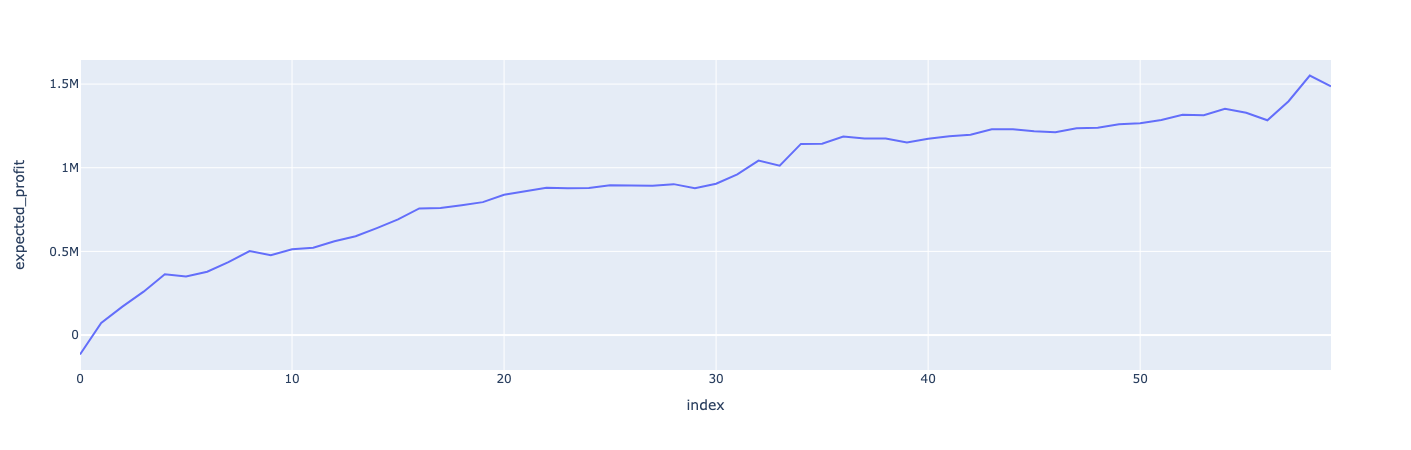

In [539]:
import plotly.express as px

fig = px.line(YearRemodAdd_df, x=YearRemodAdd_df.index, y="expected_profit")
fig.show()

## Fireplaces

In [540]:
X_valid_cp=X_valid.copy()

In [541]:
min_val_Fireplaces=X_train.Fireplaces.value_counts().index.min()

In [542]:
max_val_Fireplaces=X_train.Fireplaces.value_counts().index.max()

/Users/a420777/opt/anaconda3/envs/whatif/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




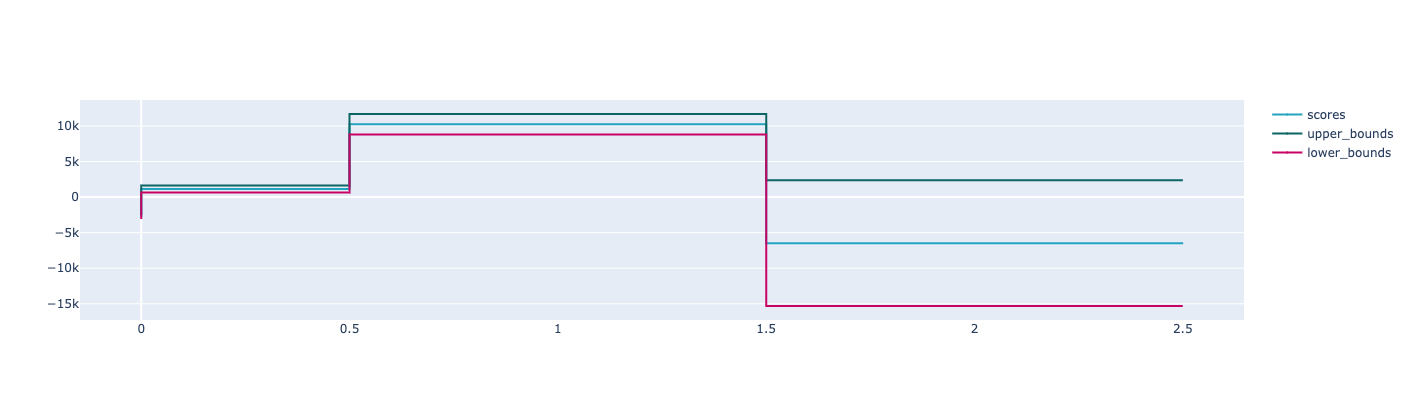

In [543]:
create_time_series(global_df, "Fireplaces")

In [544]:
def Fireplaces_addone(x,k):
#     x=int(x)
    
    if x+k>=max_val_Fireplaces:
        return max_val_Fireplaces
    
    elif x+k<=min_val_Fireplaces:
        return min_val_Fireplaces
    
    else:
        return x+k

In [545]:
Fireplaces_result={}
# for i in range(-(max_val_Fireplaces-min_val_Fireplaces),(max_val_Fireplaces-min_val_Fireplaces)):
for i in range(0,max_val_Fireplaces-min_val_Fireplaces):
    X_valid_cp=X_valid.copy()
    X_valid_cp["Fireplaces"]=X_valid_cp["Fireplaces"].apply(Fireplaces_addone, args={i})
    Fireplaces_pred=ebm.predict(X_valid_cp)
    exp_profit=np.sum(Fireplaces_pred-y_valid.values)
    Fireplaces_result[i]=exp_profit
    

In [546]:
Fireplaces_df=pd.DataFrame(data=Fireplaces_result.values(),index=Fireplaces_result.keys(), columns=["expected_profit"])

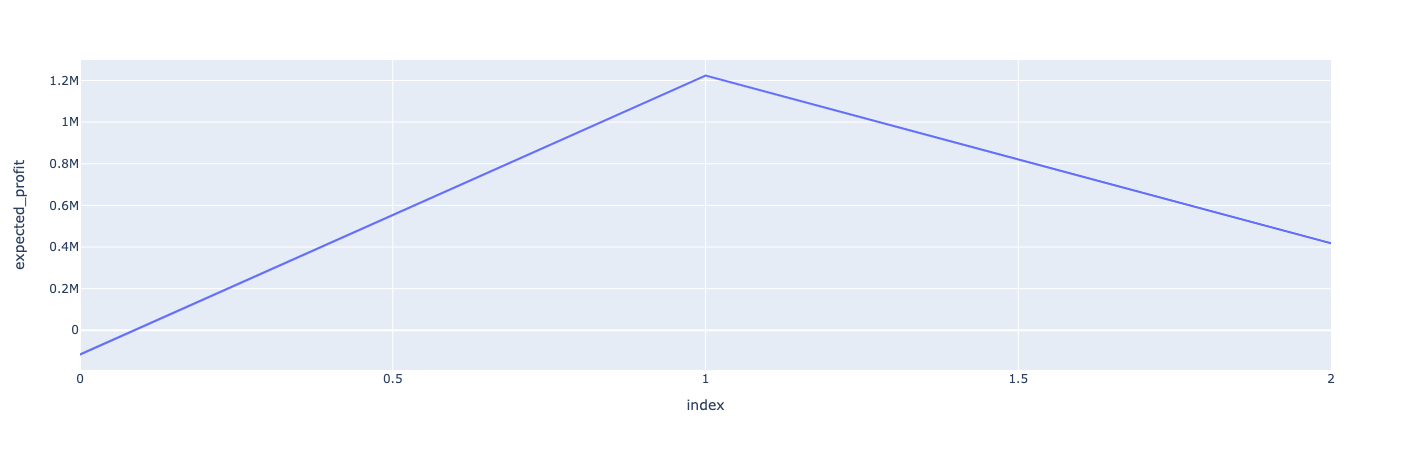

In [547]:
import plotly.express as px

fig = px.line(Fireplaces_df, x=Fireplaces_df.index, y="expected_profit")
fig.show()

# Categorical Features

In [558]:
top_avl_features_obj

Index(['RoofStyle', 'RoofMatl', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'Heating', 'CentralAir', 'KitchenQual', 'Functional',
       'FireplaceQu', 'GarageType', 'GarageQual', 'GarageCond', 'SaleType',
       'SaleCondition'],
      dtype='object')

## RoofMatl

In [519]:
X_valid_cp=X_valid.copy()

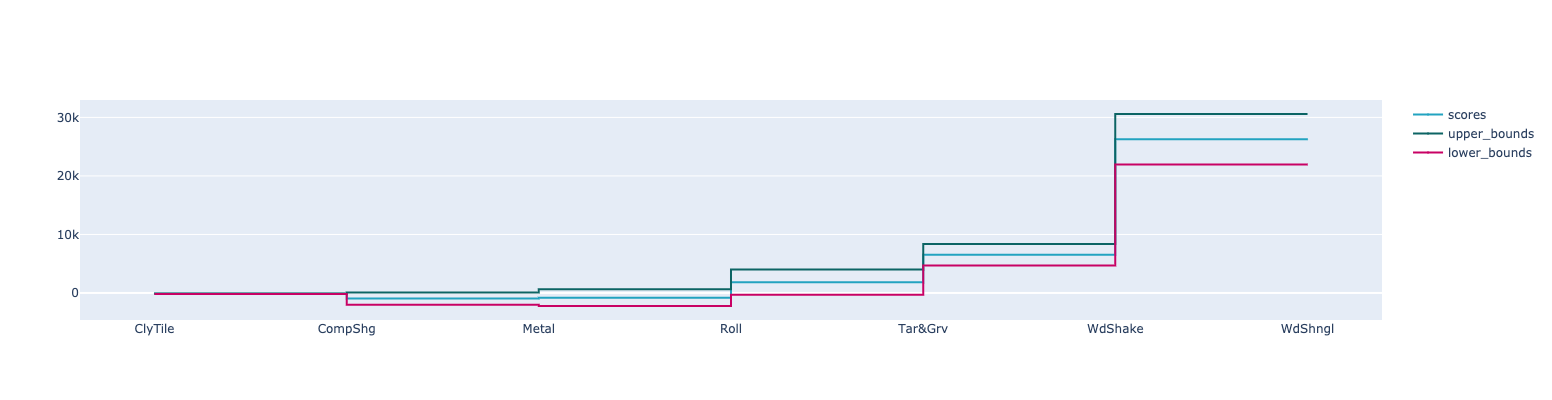

In [548]:
create_time_series(global_df, "RoofMatl")

In [568]:
RoofMatl_result={}

for option in X_train.RoofMatl.unique().tolist():
    X_valid_cp=X_valid.copy()
    X_valid_cp["RoofMatl"]=option
    
    RoofMatl_pred=ebm.predict(X_valid_cp)
    pred=ebm.predict(X_valid)
#     exp_profit=np.mean(RoofMatl_pred-y_valid.values)
    exp_profit=np.mean(RoofMatl_pred-pred)
    RoofMatl_result[option]=exp_profit
    

In [569]:
RoofMatl_df=pd.DataFrame(data=RoofMatl_result.values(),index=RoofMatl_result.keys(), columns=["expected_profit"])

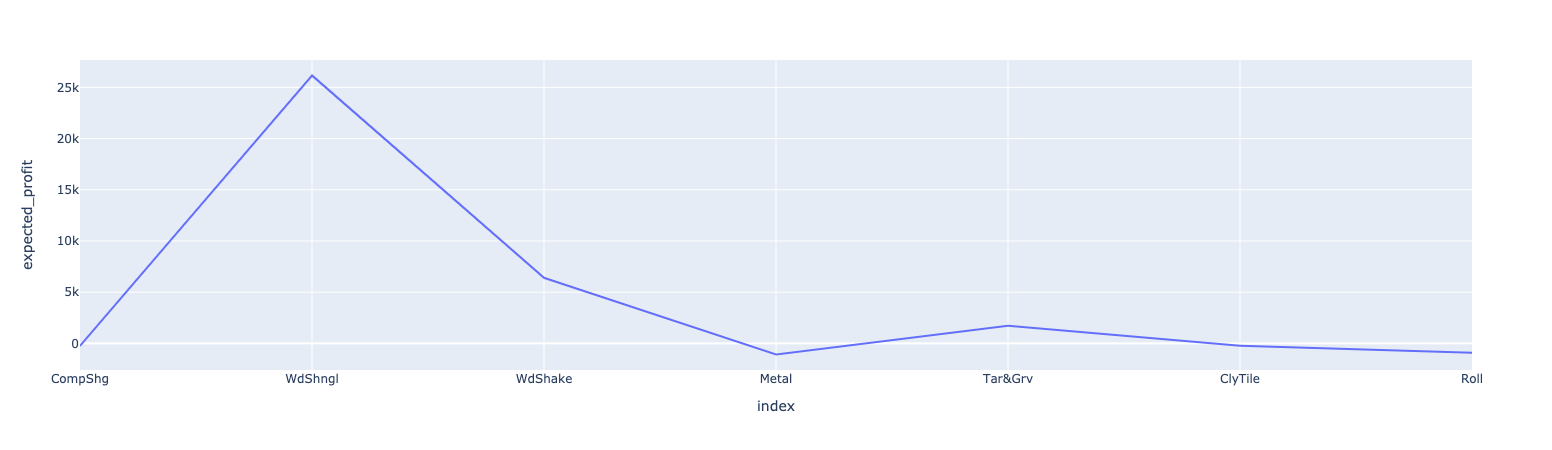

In [570]:
import plotly.express as px

fig = px.line(RoofMatl_df, x=RoofMatl_df.index, y="expected_profit")
fig.show()

## GarageType

In [559]:
X_valid_cp=X_valid.copy()

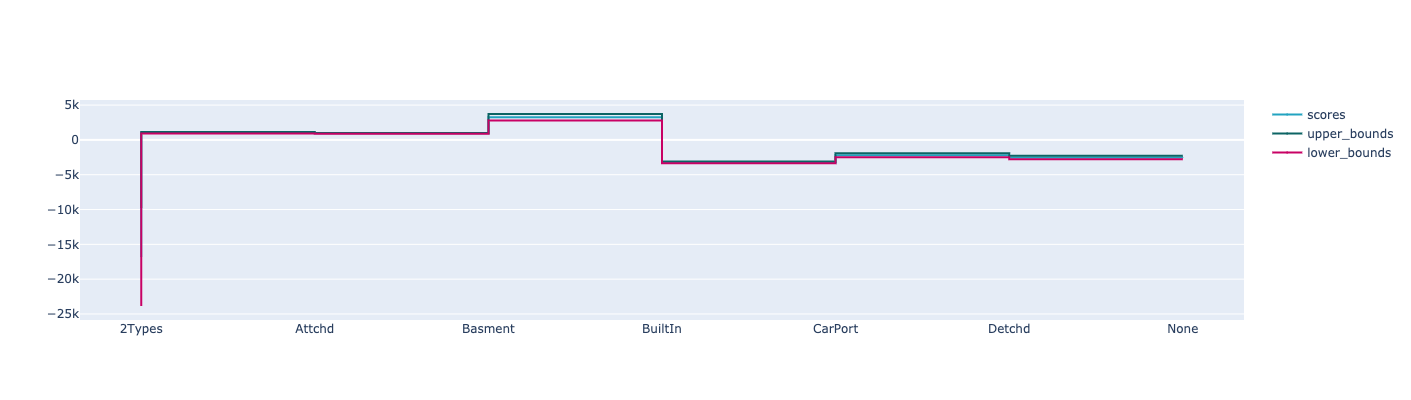

In [560]:
create_time_series(global_df, "GarageType")

In [561]:
GarageType_result={}

for option in X_train.GarageType.unique().tolist():
    X_valid_cp=X_valid.copy()
    X_valid_cp["GarageType"]=option
    
    GarageType_pred=ebm.predict(X_valid_cp)
    
    exp_profit=np.sum(GarageType_pred-y_valid.values)
    GarageType_result[option]=exp_profit
    

In [562]:
GarageType_df=pd.DataFrame(data=GarageType_result.values(),index=GarageType_result.keys(), columns=["expected_profit"])

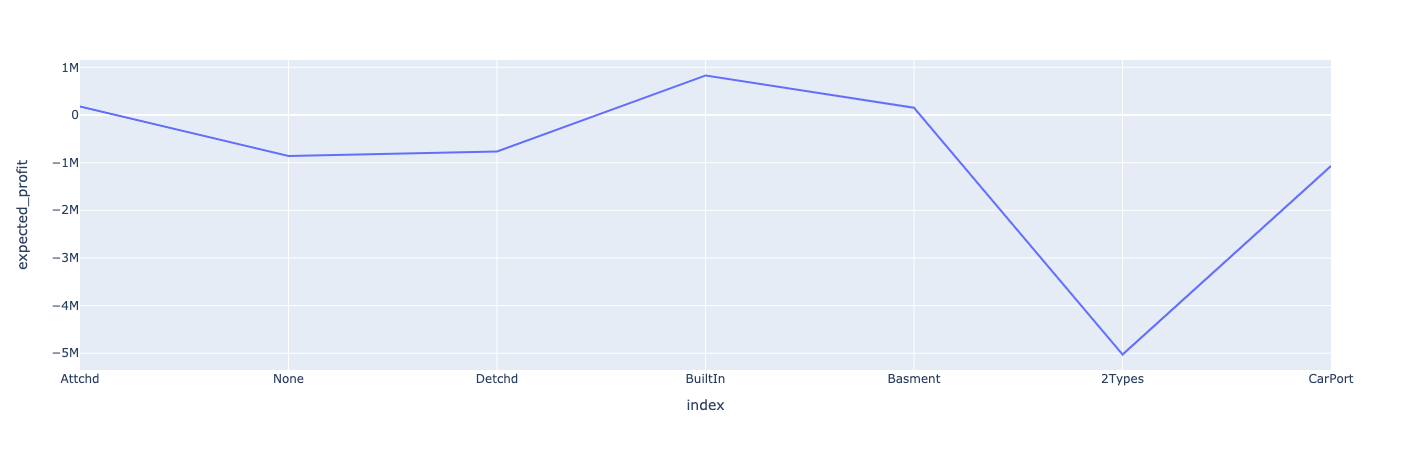

In [563]:
import plotly.express as px

fig = px.line(GarageType_df, x=GarageType_df.index, y="expected_profit")
fig.show()

## RoofMatl

In [519]:
X_valid_cp=X_valid.copy()

In [548]:
create_time_series(global_df, "RoofMatl")

In [553]:
RoofMatl_result={}

for option in X_train.RoofMatl.unique().tolist():
    X_valid_cp=X_valid.copy()
    X_valid_cp["RoofMatl"]=option
    
    RoofMatl_pred=ebm.predict(X_valid_cp)
    
    exp_profit=np.sum(RoofMatl_pred-y_valid.values)
    RoofMatl_result[option]=exp_profit
    

In [554]:
RoofMatl_df=pd.DataFrame(data=RoofMatl_result.values(),index=RoofMatl_result.keys(), columns=["expected_profit"])

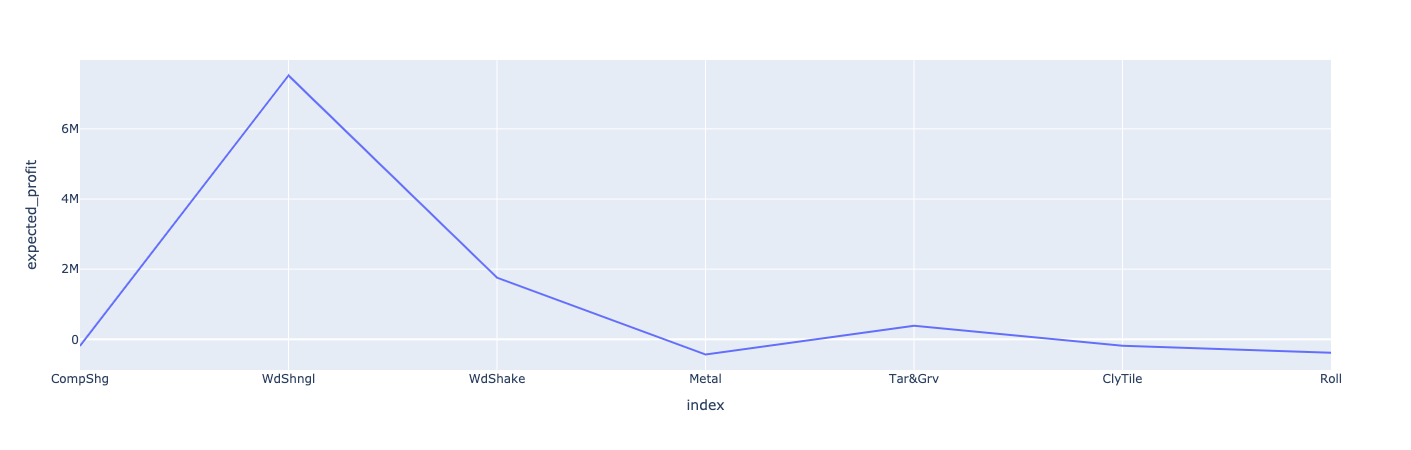

In [555]:
import plotly.express as px

fig = px.line(RoofMatl_df, x=RoofMatl_df.index, y="expected_profit")
fig.show()